# Cognitive Services Personalizer 
https://github.com/Azure-Samples/cognitive-services-personalizer-samples

In this example, we will use Azure Personalizer Service to predict what Coffee a person (Alice, Bob, Cathy and Dave) prefers given the weather condition and time of day. File "example.json" contains their preferred choices of Coffee (set deterministically for the simplicity of this example). We will compare this data with the predictions from the service and generate rewards (0 or 1) based on the match and send it back to the service for training the model.

Note that a model is exported every 5 minutes (current default) if you are using the Cognitive Services instance of the Personalizer service, so you need to wait at least until that time has expired then to actually observe some learning in the rewards returned. Exploration is set at 20%.

Current implementation calls the Personalizer service through http calls. We will replace this with a python client in the future.

In [2]:
import json
import matplotlib.pyplot as plt
import random 
import requests
import time
import uuid
from pandas import DataFrame
from Scipy import stats

In [4]:
# Replace 'personalization_base_url' and 'subscription_key' with your valid endpoint values.
endpoint = "https://westus2.api.cognitive.microsoft.com/"
personalization_base_url = endpoint # "http://localhost:5000"
subscription_key = "3a1ab38574454951a75eb7c9abfdd924" 

In [117]:
personalization_rank_url = personalization_base_url + "/personalizer/v1.0/rank"
personalization_reward_url = personalization_base_url + "/personalizer/v1.0/events/" #add "{eventId}/reward"
headers = {'Ocp-Apim-Subscription-Key' : subscription_key, 'Content-Type': 'application/json'}

examplepath = "example.json"
requestpath = "rankrequest.json"
actionfeaturespath = "actionfeatures.json"

random.seed(time.time())

userpref = None 
rankactionsjsonobj = None 
actionfeaturesobj = None

with open(examplepath) as handle:
    userpref = json.loads(handle.read())

with open(requestpath) as handle:
    rankactionsjsonobj = json.loads(handle.read())  
    
with open(actionfeaturespath) as handle:
    actionfeaturesobj = json.loads(handle.read())

In [114]:
DataFrame(userpref)

,Alice,Bob,Cathy,Dave
Rainy,"{'Morning': 'Latte', 'Afternoon': 'Cappucino',...","{'Morning': 'Latte', 'Afternoon': 'Latte', 'Ev...","{'Morning': 'Cappucino', 'Afternoon': 'Latte',...","{'Morning': 'Latte', 'Afternoon': 'Latte', 'Ev..."
Snowy,"{'Morning': 'Cappucino', 'Afternoon': 'Cappuci...","{'Morning': 'Iced mocha', 'Afternoon': 'Iced m...","{'Morning': 'Cold brew', 'Afternoon': 'Iced mo...","{'Morning': 'Cappucino', 'Afternoon': 'Cappuci..."
Sunny,"{'Morning': 'Cold brew', 'Afternoon': 'Iced mo...","{'Morning': 'Cappucino', 'Afternoon': 'Iced mo...","{'Morning': 'Latte', 'Afternoon': 'Cold brew',...","{'Morning': 'Iced mocha', 'Afternoon': 'Iced m..."


In [125]:
DataFrame(actionfeaturesobj)

,features,id
0,"[{'type': 'hot', 'origin': 'kenya', 'organic':...",Cappucino
1,"[{'type': 'cold', 'origin': 'brazil', 'organic...",Cold brew
2,"[{'type': 'cold', 'origin': 'ethiopia', 'organ...",Iced mocha
3,"[{'type': 'hot', 'origin': 'brazil', 'organic'...",Latte


In [74]:
def get_reward_from_simulated_data(name, weather, timeofday, prediction):
    if(userpref[name][weather][timeofday] == str(prediction)):
        return 1 
    return 0

In [75]:
def create_event_id(rankjsonobj):
    eventid = uuid.uuid4().hex
    rankjsonobj["eventId"] = eventid
    return rankjsonobj, eventid

In [100]:
def add_random_features(rank_request):
    'Fill the request fields with random name, weather and timeofday features.'
    name = random.choice(namesopt)
    weather = random.choice(weatheropt)
    timeofday = random.choice(timeofdayopt)
    rank_request['contextFeatures'] = [{'timeofday': timeofday, 'weather': weather, 'name': name}]
    features = [name, weather, timeofday]
    return rank_request, features

In [131]:
def add_action_features(rank_request):
    rank_request["actions"] = actionfeaturesobj[1:2]
    return rank_request

In [78]:
def summary_context(c_vector):
    'Moniker with the first letter of each context. To see the state at each step.'
    first_ltr = [str(k[0]) for k in c_vector]
    return ''.join(first_ltr)

In [147]:
# Reset the data
recommendations = 0
reward = 0
rewards = []
count = []
icount = []
irewards = []
rankjsonobj = rankactionsjsonobj
    
namesopt = ['Alice', 'Bob', 'Cathy', 'Dave']
weatheropt = ['Sunny', 'Rainy', 'Snowy']
timeofdayopt = ['Morning', 'Afternoon', 'Evening']

In [137]:
# Test random context generation
_, xc = add_random_features(rankjsonobj)
summary_context(xc)

'CSA'

In [151]:
num_requests =  4000 # 10000
print( add_action_features(rankjsonobj))

for i in range(num_requests):
      
    ## Fill in the rank-request object 
    #create unique id to associate with an event
    rankjsonobj, eventid = create_event_id(rankjsonobj)
    #generate random context
    rankjsonobj, features = add_random_features(rankjsonobj)
    [name, weather, timeofday] = features
    #add the actions to be ranked
    rankjsonobj = add_action_features(rankjsonobj)
    #choose an action
    response = requests.post(personalization_rank_url,
                             headers = headers,
                             params = None,
                             json = rankjsonobj)
    if response.status_code //  100 != 2:
        print(i, "\tBad context response: ", response.status_code)
        
    #compare personalization service recommendation with the simulated data to generate a reward value
    prediction = json.dumps(response.json()["rewardActionId"]).replace('"','')
    reward = get_reward_from_simulated_data(name, weather, timeofday, prediction)
    
    #send the reward to the service 
    response = requests.post(personalization_reward_url + eventid + "/reward",
                             headers = headers,
                             params= None,
                             json = { "value" : reward })
    if response.status_code //  100 != 2:
        print(i, "\tBad reward response: ", response.status_code)
    #for every 10 rank request compute total correct recommendations 
    recommendations = recommendations + reward
    
    iplus = i + 1
    #wait (>1 min) between sending more events to observe learning in the next batch
    if(iplus % 500 == 0):
        time.sleep(61) 
               
    if(iplus % 10 == 0): 
        print(summary_context( [name, weather, timeofday] ), ':{0:d} '.format(reward), sep='', end = ' ')
        rewards.append(recommendations)
        count.append(i)
        recommendations = 0

print("\nTotal of {}  rewards ".format(10* len(rewards)))

{'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Snowy', 'name': 'Dave'}], 'actions': [{'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}], 'excludedActions': [], 'eventId': '0bf1b73f92774bf396ff5a50c9a4d022', 'deferActivation': False}
DSM:0  CRA:0  BSM:0  CSE:0  CSA:1  DRE:0  DRM:0  CSM:0  BRE:0  CSM:1  DRE:0  ASA:0  DSA:0  ASA:0  ASA:0  BSA:0  CSM:0  CRE:0  ARA:0  CSE:0  ASE:1  DSA:0  ASE:0  DSA:0  CRE:0  CSE:0  ARM:0  CRE:0  BRM:0  ARA:0  BSM:0  DSE:0  CRM:0  ASE:1  BSA:0  ASA:0  BSE:1  BSE:1  DSA:0  DRM:0  DRE:0  DSA:0  DRA:0  BRA:0  CSE:0  CRE:0  BSE:1  BSA:0  DRA:0  BSE:1  ASA:0  DRE:0  DSA:0  CSM:1  CSM:1  BRA:0  DSM:0  BSM:0  CSA:1  CSM:1  DSE:0  ARA:0  ASA:0  BRE:0  ASE:1  DRA:0  BRM:0  ASM:1  BSM:0  BRE:0  CRE:0  BSE:1  DSE:0  BSE:1  ASA:0  BSE:1  CSA:0  BSM:0  ARE:0  BRE:0  CRA:0  BRM:0  CSE:0  BRM:0  ASE:0  CSE:0  DSE:0  DRE:0  ARA:0  CSA:0  DRE:0  CRE:0  ARM:0  ASA:0  CSA:0  DRA:0  ASE:0  BSE:1  ASA:0  BSE:1

Plot total number of correct recommendations for every batch of 10 events.

In [152]:
lm = stats.linregress(count, rewards)
y = [lm.slope * c + lm.intercept for c in count]
print(lm.slope)

-2.2944594990364723e-05


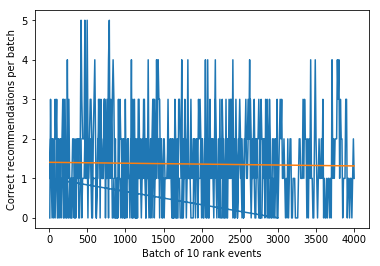

In [153]:

plt.plot(count, rewards)
plt.plot(count, y, '-')
plt.xlabel("Batch of 10 rank events")
plt.ylabel("Correct recommendations per batch")
plt.show()

From the above plot, you can observe that the ranking gets better after ~2000 events and performs well over ~80% of the time. Since, the exploration is set to 20%, 20% of the time the system still tries to explore the other options. See https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/ for more documentation.